### Wholebody CT Segmentation in Python Tutorial 
https://youtu.be/NA8_Yi_q7X4?si=3k5xBG0p4Rux8vTc

In [1]:
import os
import numpy as np
import torch
import pydicom
import matplotlib.pyplot as plt
from tcia_utils import nbia
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder

/Users/adamkurth/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/adamkurth/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/adamkurth/anaconda3/envs/torch/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/adamkurth/anaconda3/envs/torch/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


AttributeError: partially initialized module 'cv2' has no attribute 'dnn' (most likely due to a circular import)

## Option 1: Using `dicom`
Data was obtained using the cancer imaging archive. 

In [2]:
data_dir = 'images/'
cart_code = 'nbia-72791704609866986'
cart_data = nbia.getSharedCart(cart_code)
# df = nbia.downloadSeries(cart_data, format='df', path=data_dir) # large download

2024-01-07 10:59:48,739:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName with parameters {'name': 'nbia-72791704609866986'}


In [5]:
CT_dir = os.path.join('1.3.6.1.4.1.14519.5.2.1.1600.1202.167290236636236012179587075735')

In [7]:
ds = pydicom.read_file(os.path.join(CT_dir, '1-134.dcm'))
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.1600.1202.282663851976624487101682444269
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.

In [8]:
image = ds.pixel_array
image.shape

(512, 512)

Note that the image is a 2D array. Specific units called *Hounsfield Units (HU)* are the standard for reading CT images. We need to convert these to HU.

Each pixel value stored in a scaled format so we should adjust them:

-1000 thought of as air, 0 as water, and 1000 as bone.

In [9]:
image = ds.RescaleSlope * image + ds.RescaleIntercept

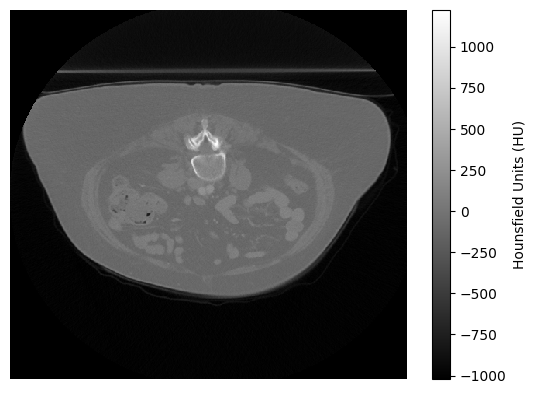

In [10]:
plt.pcolormesh(image, cmap='gray')
plt.colorbar(label='Hounsfield Units (HU)')
plt.axis('off')
plt.show()

## Option 2: Using `monai`

MONAI stands for Medical Open Network for Artificial Intelligence, and essentially is an extension of PyTorchfor machine learning with medical data. If you're doing AI research in medicine, you **MUST** use MONAI.

MONAI has functionality for easily opening medical data.

In [20]:
image_loader = LoadImage(image_only=True)
CT = image_loader(CT_dir)
CT.meta 
CT.shape

torch.Size([512, 512, 203])

Note that this is only a 3d array, for PyTorch we need both a *channel* and *batch* dimensions to be added.

This `.meta` has much information to give context of the image. Such as: 
- pixel spacing: 0.93554688 mm resolution in the axiol plane, and 3 mm along the z axis between slices.
- lastImagePositionPatient: position of patient
- the two tensors: when there is two pictures (scans) and the position of the pateient is different, this lines them up. 

Proceed by taking a look at a *coronal slice* (i.e. face forward)

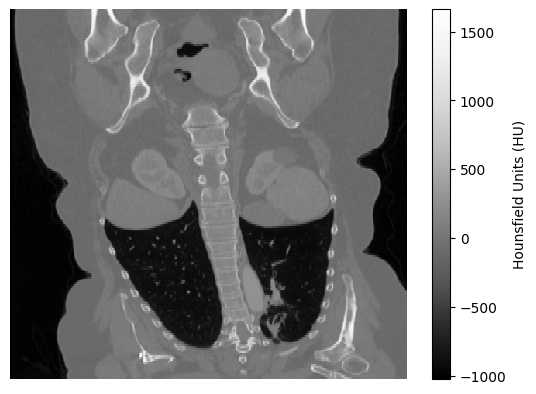

In [19]:
CT_coronal_slice = CT[:,250].cpu().numpy()
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='Hounsfield Units (HU)')
plt.axis('off')
plt.show()


Add a channel dimension:

In [44]:
channel_transform = EnsureChannelFirst()
CT = channel_transform(CT)
# CT = CT.squeeze(0)
CT.shape

torch.Size([1, 512, 512, 203])

Reorient the image: 
LPS = Left Posterior Superior

In [48]:
orientation_transform = Orientation(axcodes=('RAS'))
CT = orientation_transform(CT)

Obtain the coronal slice:

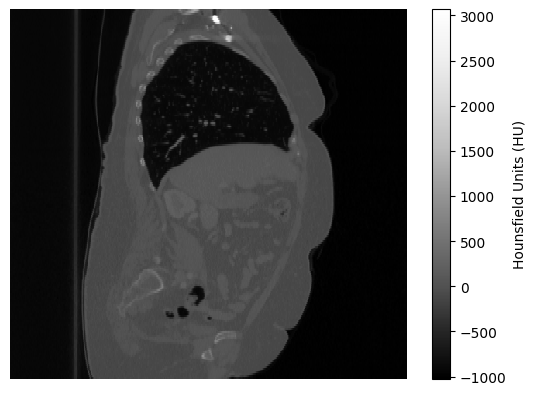

In [49]:
CT_coronal_slice = CT[0,250].cpu().numpy()
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='Hounsfield Units (HU)')
plt.axis('off')
plt.show()

To do all of this at once using MONAI, we use the compose functionality which gives a data pipeline.

In [50]:
preprocessing_pipeline = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Orientation(axcodes=('RAS')),
])
CT = preprocessing_pipeline(CT_dir)
CT_coronal_slice = CT[0,250].cpu().numpy()

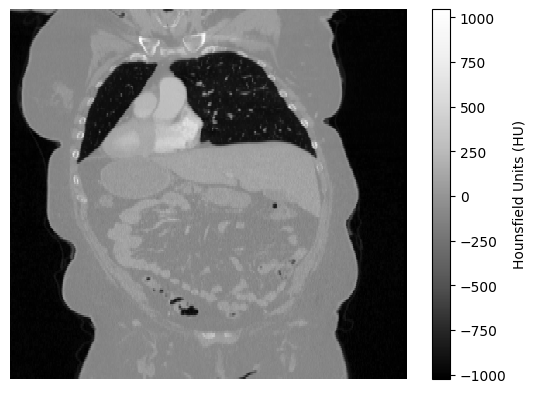

In [72]:

# CT_coronal_slice = np.rot90(CT_coronal_slice, k=1, axes=(0,1))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='Hounsfield Units (HU)')
plt.axis('off')
plt.show()

One other option (typically done) is to use a dictionary version of all of the transforms above. This is done by adding a `d` to the end of the transforms such as `LoadImaged`. 
- These transforms take in a dictionary with keys-value pairs.


In [75]:
data = {'image': CT_dir, 'other_key': 23}

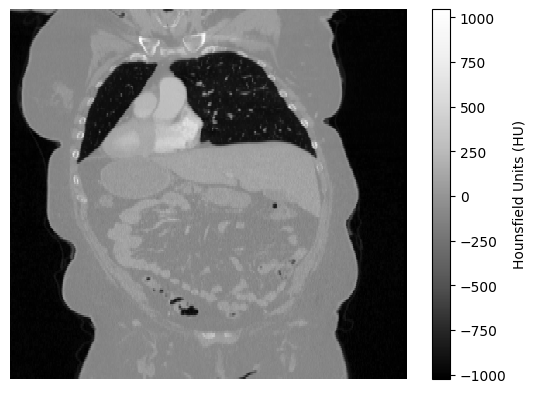

In [73]:
preprocessing_pipeline = Compose([
    LoadImaged(keys='image', image_only=True),
    EnsureChannelFirstd(keys='image'),
    Orientationd(keys='image', axcodes=('RAS')),
])

plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='Hounsfield Units (HU)')
plt.axis('off')
plt.show()

In [78]:
data = preprocessing_pipeline(data)
data

{'image': metatensor([[[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           

Using a pipeline approach allows for easy manipulation for images of other types. This could be CT to CT comparision, or PET and CT, etc.

## Part 2: Segmentation Model

Download the segmentation model from https://monai.io/model-zoo.html

In [81]:
model_name = 'wholeBody_ct_segmentation'
# download(name=model_name, bundle_dir='data_dir') #had to manually download

From `wholeBody_ct_segmentation/configs/inference.json` and `wholeBody_ct_segmentation/configs/metadata.json` we find: 
- Model outputs integers which correspond to organ locations. 
  - For example `"2": "kidney_right",`

Adjustments to `inference.json` include deleting cuda option, output_dir, etc. 

In [94]:
model_path = os.path.join('wholeBody_ct_segmentation', 'models', 'model_lowres.pt')
config_path = os.path.join('wholeBody_ct_segmentation', 'configs', 'inference.json')


From this we create a `config` instance which lets us read from the `json` file.

In [95]:
config = ConfigParser()
config.read_config(config_path)


##  Preprocessing Pipeline
From this we extract the preprocessing pipeline specified by `inference.json` file.
- There are all the operations applied to the data before being fed into the model. 


In [96]:
preprocessing = config.get_parsed_content('preprocessing')

Note that this preprocessing pipeline uses `LoadImaged` instead of `LoadImage`. Recall that this uses the keys argument in the dictionary to apply the transform. 

In [97]:
data = preprocessing({'image': CT_dir})
data

{'image': metatensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          ...,
 
          [[-1., -1., -1.,  ...

The -1's are normalizing the intensity of the image from -1 to 1.

## Model
Now we obtain the model by using the `network` key from the json file. 



In [98]:
model = config.get_parsed_content('network')

Note at the moment the model is initialized with random parameters. We need to configure it with the parameters given by the `model.pt` file. Since we won't be training it (only evaluating) we'll use the `eval()` function. The already instantialized parameters are in `model_low_res.pt`.

In [100]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, a

## Inferer

THe `"inferer"` pipeline takes the data and the model, and returns the model output. It contains some extra processing steps (in this case it breaks the data into 96x96x96 chunks before feeding it into the model).

In [101]:
inferer = config.get_parsed_content('inferer')

## Post-Processing
Finally, once the model has finished running, there will be postprocessing that needs to be done on the data. 
- **IMPORTANT**: The postprocessing automatically saves the data to disk. I have manually deleted the `"SaveImaged"` from postprocessing pipeline in the json file.

In [102]:
postprocessing = config.get_parsed_content('postprocessing')

 ## Prediction:

 We can now combine these pipelines to obtain organ masks. 

In [144]:
data = preprocessing({'image': CT_dir}) # returns dict
with torch.no_grad():
    # additional dimension for batch
    data['pred'] = inferer(data['image'].unsqueeze(0), network=model)

# remove batch dimension in image and pred
data['pred'] = data['pred'][0]
data['image'] = data['image'][0]
# postprocessing
data = postprocessing(data)
segmenation = torch.flip(data['pred'], dims=[2])
segmenation = segmenation.cpu().numpy()

2024-01-07 16:59:28,157 INFO image_writer.py:197 - writing: /Users/adamkurth/Documents/vscode/python_4_fun/ct_segmentation/data/mask/1.3.6.1.4.1.14519.5.2.1.1600.1202/1.3.6.1.4.1.14519.5.2.1.1600.1202_trans.nii.gz


In [177]:
slice_idx = 250
CT_coronal_slice = CT[0,:, slice_idx].cpu().numpy()
segmentation_coronal_slice = segmenation[0,slice_idx]


In [178]:
CT_coronal_slice.shape


(512, 203)

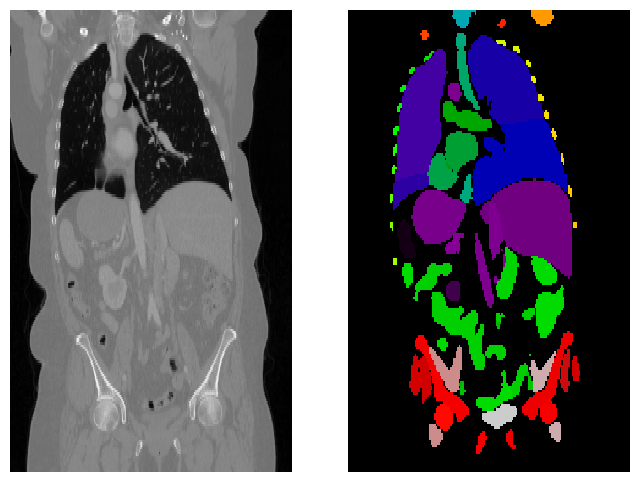

In [179]:
segmentation_coronal_slice = np.flip(data['pred'][0, :, 250, :].cpu().numpy())

plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(segmentation_coronal_slice.T, cmap='nipy_spectral')
plt.axis('off') 
plt.show()

We see that each color corresponds to a different organ in the image.
- Radiotherapy planning to avoid certain organs
- Utilization of SPECT/PET reconstruction algorithms to improve quantification
- Calculate organ volumes

**Example**: Check key 104 (urinary bladder):

In [182]:
num_bladder_voxels = (segmenation==104).sum().item()
voxel_volume_cm3 = np.prod(CT.meta['spacing']/10)
bladder_vol = num_bladder_voxels * voxel_volume_cm3
print(f'Bladder volume: {bladder_vol:.2f} cm^3')

Bladder volume: 50.34 cm^3
